## Fine tuning a Norwegian language BERT model 

In [1]:
# sklearn (vectorizer, classifier, gridsearch)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt


# For tuning and training
import torch.nn as nn
import torch
from transformers import AutoModelForSequenceClassification
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer
)
import evaluate


# Auxiliary
from random import shuffle
import pickle
import pandas as pd 
import numpy as np 
import json
import os
import os.path



In [2]:
# Tagging the data points with positive or negative

class TaggedPoint():
    def __init__(self, data, tag):
        self.data = data
        self.tag = tag

In [3]:
# opens the folder as per my file system and filters data based on rating and screen
# processing it norwegian text

with open("./norec-master/norec-master/data/metadata.json", "r", encoding="utf-8") as file:
    data = json.load(file)  
    filtered_data = {k:v for k,v in data.items() if v["category"] == "screen"}

    neg_reviews = {k:v for k,v in filtered_data.items() if v["rating"] in [1,2,3]}
    pos_reviews = {k:v for k,v in filtered_data.items() if v["rating"] in [5,6]}
    
print(type(data))
print("Negative reviews: ", len(neg_reviews))
print("Positive reviews: ", len(pos_reviews))

<class 'dict'>
Negative reviews:  5246
Positive reviews:  5166


In [4]:
# count files in directories

fp = "./norec-master/norec-master/data/"


def count_files(path):
    count = 0
    for i in os.listdir(path):
        count += 1
    print(count)
    return count


test_count = count_files(fp+"test")
dev_count = count_files(fp+"dev")
train_count = count_files(fp+"train")

4340
4348
34749


In [5]:
%%time
# takes the key values in the dictionary items and adds .txt to them for easy comparison in dev, test, train folder
# by adding the data as TaggedPoint-objects, we can easily reuse many of the supplied functions


def get_files(path):
    global neg_reviews, pos_reviews
    id_neg = [k+".txt" for k in neg_reviews.keys()]
    id_pos = [k+".txt" for k in pos_reviews.keys()]
    data = []

    for file in os.listdir(path):
        fn = path+file
        if os.path.isfile(fn):
            if file in id_neg:
                with open(fn, "r", encoding="utf-8") as file:
                    content = file.read()
                    data.append(TaggedPoint(content, 0))
            elif file in id_pos:
                with open(fn, "r", encoding="utf-8") as file:
                    content = file.read()
                    data.append(TaggedPoint(content, 1))


    return data # return list with tagged points

test = get_files("./norec-master/norec-master/data/test/")
val = get_files("./norec-master/norec-master/data/dev/")
train = get_files("./norec-master/norec-master/data/train/")

print(f"Test set: {len(test)},  Validation set: {len(val)},  Train set: {len(train)}")

Test set: 1006,  Validation set: 1054,  Train set: 8352
CPU times: total: 5.59 s
Wall time: 1min 48s


In [6]:
# Importing articles into 

def get_sami_test_files(path):
    data = []

    for fn in os.listdir(path):
        fp = path+fn
        if os.path.isfile(fp):
            with open(fp, "r", encoding="latin-1") as file:
                content = file.read()
                data.append(TaggedPoint(content, None))
    return data


# getting testfiles
lp_test = get_sami_test_files("./test/")
print("Data: \n", lp_test[0].data, "\n\n",
       "Label: \n", lp_test[0].tag)

Data: 
 nei til sameflagg 17. mai  
et flertall i oslo bystyre gÃ¥r inn for at det ikke skal heises sameflagg
pÃ¥ oslo kommunes flaggstenger  17. mai. samene er skuffet.  
nei dette synet, det samiske flagget ved siden av det norske  flagget,
kommer man ikke til Ã¥ fÃ¥ se pÃ¥ oslo kommunes flaggstenger 17. mai.
foto scanpix      
avgjÃ¸relsen ble tatt under bystyrets  mÃ¸te onsdag kveld. et flertall
bestÃ¥ende av ap, hÃ¸yre,  frp og krf gikk inn for at det ikke blir sameflagg
i oslo.  
det var sv, venstre og rv som foreslo at det samiske flagget  ogsÃ¥ kan
vÃ¦re representert pÃ¥ kommunens flaggstenger  17. mai. bakgrunnen er
at det samiske flagget ble likestilt med  det norske i 2003.  
lederen i oslo sameforening, ingrid jÃ¥ma,  er skuffet over avgjÃ¸relsen
 sameflagget er et offisielt flagg, og det ville  vÃ¦rt helt naturlig
Ã¥ heise det i oslo 17. mai. vi  er stolte av det samiske flagget, og
vi er stolte av kulturen  vÃ¥r. Ã¥ bruke det samiske flagget i oslo 17.
mai, ville  vÃ¦rt e

#### Inspecting and choosing padding length

Text(0, 0.5, 'Frquency of words per text')

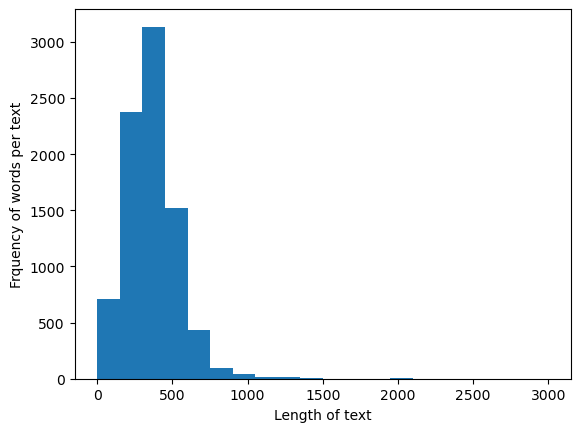

In [7]:

train_lens = [len(i.data.split()) for i in train] 
plt.hist(train_lens,
         bins=20,
         range=(0,3000),
         histtype='stepfilled',)
plt.xlabel("Length of text")
plt.ylabel("Frquency of words per text")

#### Creating the datasets used in training of the BERT and baseline model

In [8]:
from datasets import Dataset
# to insure that the model has not memorized any patterns
def shuffle_split(test, val, train):
    shuffle(test)
    shuffle(val)
    shuffle(train)
    return test, val, train


test_set, val_set, train_set = shuffle_split(test, val, train)
print("1: ", type(test_set), type(val_set), type(train_set))
#print(test_set)


def dictify(li):
    data = {"label":[], "text":[]}
    for item in li:
        data["label"].append(item.tag)
        data["text"].append(str(item.data))
    return data


test_set = dictify(test_set)
val_set = dictify(val_set)
train_set = dictify(train_set)
print("2: ", type(test_set), type(val_set), type(train_set))


test_set = Dataset.from_dict(test_set)
val_set = Dataset.from_dict(val_set)
train_set = Dataset.from_dict(train_set)
print("3: ", type(test_set), type(val_set), type(train_set))
print(test_set)
print(val_set)
print(train_set)

1:  <class 'list'> <class 'list'> <class 'list'>
2:  <class 'dict'> <class 'dict'> <class 'dict'>
3:  <class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'> <class 'datasets.arrow_dataset.Dataset'>
Dataset({
    features: ['label', 'text'],
    num_rows: 1006
})
Dataset({
    features: ['label', 'text'],
    num_rows: 1054
})
Dataset({
    features: ['label', 'text'],
    num_rows: 8352
})


#### Creating dataset for unlabeled data

In [9]:
count_files("./test")

382


382

In [10]:
with open("./test_metadata.json", "r") as f:
    metadata = json.load(f)

print(len(metadata))

382


In [11]:
import json

def get_unlabelled_data(path_test, path_metadata):
    data = {"id":[], "year":[], "label":[], "text":[], "paper":[]}

    with open(path_metadata, "r", encoding="utf-8") as metafile:
        metadata = json.load(metafile)


    for fn, fd in metadata.items():

        year = fd["year"].replace("test_", "")
        paper = fd["paper"].replace("test_", "")

        fp = f"{path_test}/{fn}.txt"
        with open(fp, "r", encoding="utf-8") as tf:
            text = tf.read().strip()
        
        data["id"].append(fn)
        data["year"].append(year)
        data["label"].append(None)
        data["text"].append(text)
        data["paper"].append(paper)
    return data
    
    

unlabelled_data = get_unlabelled_data("./test", "./test_metadata.json")

# for k,v in unlabelled_data.items():
#     print(k,v, "\n")


In [12]:
unlabelled_data = Dataset.from_dict(unlabelled_data)

## Making a baseline model

In [13]:
# function that returns train features and feautres for both tfidf and countvectorizer

def get_train_features(train):
    #initialize vectorizer
    vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform([review.data for review in train])

    y_train = np.array([review.tag for review in train])

    return vectorizer, X_train, y_train



def get_features(data_set, vectorizer):

    X = vectorizer.transform([review.data for review in data_set])

    y = np.array([review.tag for review in data_set])

    return X, y


def get_secondary_features(data_set, vectorizer):
    # Note that we conscider another structure for the unlabelled test data

    X = vectorizer.transform([text for text in data_set["text"]])

    return X

In [14]:
# in order to maximize the performance of our logreg model, we use grid search to find the best params

def grid_search(X, y):
    #initialize our model
    lr = LogisticRegression(max_iter=1500)

    #create a grid of different parameters to try out during the search
    parameters = {
        # sag doesn't support "l1" -> warning
        "penalty": [None, "l1", "l2"], 
        "tol": [1e-4, 1.5e-4 ,2e-4], 
        "class_weight": [None, "balanced"], 
        "random_state": [0, 42], #, 1337],
        # We will be using sag as max_iter is >= 1000
        "solver": ["lbfgs", "sag" ,"saga", "liblinear"],
        }

        
    clf = GridSearchCV(lr, parameters, n_jobs=6, verbose=2)
    clf.fit(X, y)
    return clf

#display the results of the grid search
def print_info(grid_result):
    print(grid_result)
    for p in grid_result.param_grid:
        print("\033[92m%20s \033[93m%-12s\033[0m %s" %
        (p, grid_result.best_params_[p], grid_result.param_grid[p]))

In [15]:
# tuning-function that takes the params and training- and validation sets to give the result
# returns the classifier obejct along with displaying a matrix 

def make_best(params, X_train, y_train, X_val, y_val):
    lr = LogisticRegression(max_iter=1500,
                            penalty=params["penalty"],
                            class_weight=params["class_weight"],
                            random_state=params["random_state"],
                            solver=params["solver"],
                            tol=params["tol"],
                            )
    
    clf = lr.fit(X_train, y_train)

    print(clf.classes_)
    predictions = clf.predict(X_val)
    # print(predictions)

    print('\n\033[94mConfusion matrix:\033[0m\n',
          confusion_matrix(y_val, predictions, labels=[0, 1]))
    print(classification_report(y_val, predictions))
    
    cm = confusion_matrix(y_val, predictions, labels=[0,1])
    fig = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["0","1"])
    fig.plot(ax=plt.gca(), cmap="plasma")

    plt.show()

    return clf

#### Extracting features for TF-IDF

In [16]:
# Extracting transformed features and vectorizer

vectorizer, X_train, y_train = get_train_features(train)
X_val, y_val = get_features(val, vectorizer)
X_test, y_test = get_features(test, vectorizer)

In [17]:
# Checking if shape is properlt set

print("Train set shape: ", X_train.shape, y_train.shape, "\nTest set shape: ",  X_test.shape, y_test.shape)

Train set shape:  (8352, 151073) (8352,) 
Test set shape:  (1006, 151073) (1006,)


#### Running grid_search

In [18]:
%%time

grid_result = grid_search(X_train, y_train)
print_info(grid_result)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


c:\Users\saete\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\saete\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\saete\anaconda3\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\saete\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1172, in fit
    solver = _check_solver(self.solver, self.penalty, self.dua

GridSearchCV(estimator=LogisticRegression(max_iter=1500), n_jobs=6,
             param_grid={'class_weight': [None, 'balanced'],
                         'penalty': [None, 'l1', 'l2'], 'random_state': [0, 42],
                         'solver': ['lbfgs', 'sag', 'saga', 'liblinear'],
                         'tol': [0.0001, 0.00015, 0.0002]},
             verbose=2)
             penalty None         [None, 'l1', 'l2']
                 tol 0.00015      [0.0001, 0.00015, 0.0002]
        class_weight None         [None, 'balanced']
        random_state 0            [0, 42]
              solver lbfgs        ['lbfgs', 'sag', 'saga', 'liblinear']
CPU times: total: 7.55 s
Wall time: 25min 54s


#### Finding best classifiers for grid search using TF-IDF

[0 1]

Confusion matrix:
 [[457  64]
 [ 53 480]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       521
           1       0.88      0.90      0.89       533

    accuracy                           0.89      1054
   macro avg       0.89      0.89      0.89      1054
weighted avg       0.89      0.89      0.89      1054



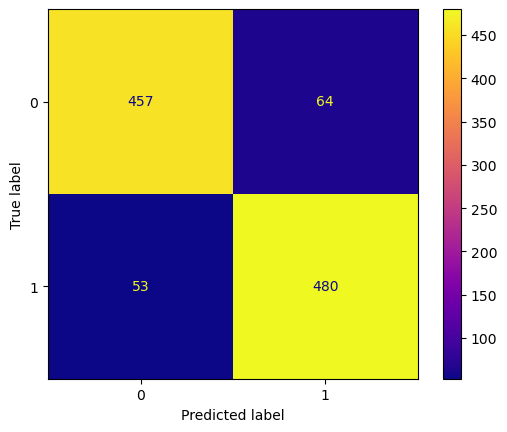

CPU times: total: 78.1 ms
Wall time: 555 ms


In [19]:
%%time 

best_classifier = make_best(grid_result.best_params_, X_train, y_train, X_val, y_val)

In [20]:
print(grid_result.best_params_)
print(type(best_classifier))

{'class_weight': None, 'penalty': None, 'random_state': 0, 'solver': 'lbfgs', 'tol': 0.00015}
<class 'sklearn.linear_model._logistic.LogisticRegression'>


#### Saving model in case of notebook failure

In [18]:
# fp = "./baseline.pkl"
# with open(fp, "wb") as f:
#     pickle.dump(best_classifier, f)


In [19]:
fp = "./baseline.pkl"
with open(fp, "rb") as f:
    loaded_model = pickle.load(f)


print(loaded_model)

LogisticRegression(max_iter=1500, penalty=None, random_state=0, solver='sag',
                   tol=0.00015)


#### Making predictions on unlabelled data

In [20]:
X_unlabelled = get_secondary_features(unlabelled_data, vectorizer)

In [21]:
predictions = loaded_model.predict(X_unlabelled)

In [22]:
print(predictions)
print(len(predictions))
baseline_data = unlabelled_data

print(baseline_data)
baseline_data = baseline_data.remove_columns("label")
baseline_data = baseline_data.add_column("label", predictions)

print(baseline_data["label"])

[0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1
 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1
 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1
 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1
 1 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0
 0 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 0
 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0
 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1
 0 1 1 1 1 1 1 0 1 0 1 0]
382
Dataset({
    features: ['id', 'year', 'label', 'text', 'paper'],
    num_rows: 382
})
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 

#### Random control samples for the dataset


In [23]:
import random

sample = random.sample(range(len(predictions)), 5)


In [27]:
# We will extract 10 random samples. The samples will be saved so we can see if the bert model classifies similarily
print("Randomly chosen list indices: ", sample)
eval_list = list(zip(baseline_data["label"], baseline_data["text"]))

for s in sample:
    if eval_list[s][0] == 0:
        temp = "Positive/1"
    else: 
        temp = "negative/0"
    print("-"*30)
    print(f"This text have been classified as: {temp}\n\n")
    print(eval_list[s][1], "\n")


Randomly chosen list indices:  [283, 44, 321, 202, 164]
------------------------------
This text have been classified as: negative/0


test av høstens nye flatskjermer
bladet lyd og bilde har testet seks av høstens nye flatskjermer. foto
lyd og bilde      
av  audun hage, lyd og bilde  og darren waring, lyd og bilde  16.09.2010
kl. 1040 kilde vg nett  
den som får led sist, har led best! høstens tvslipp gir deg ledskjermer
med super kvalitet til en overkommelig pris. 
ledteknologien gjør flatskjermene enda flatere enn før.
 det verste slankehysteriet begynner faktisk å gi seg blant tvprodusentene.
de tynne tvene er i praksis blitt tynne nok. nå er det igjen fokus
på bildekvalitet, finesser og tilkoblingsmuligheter, oppsummerer journalist
audun  hage i lyd  bilde.
det som i butikken markedsføres som ledtv, er strengt tatt fremdeles
lcdskjermer. lcdskjermer har vært med oss i mange år. en lcdskjerm
har en fast lyskilde bakerst, og et lag med flytende krystaller foran.
krystallene  åpner 

<class 'datasets.arrow_dataset.Dataset'>


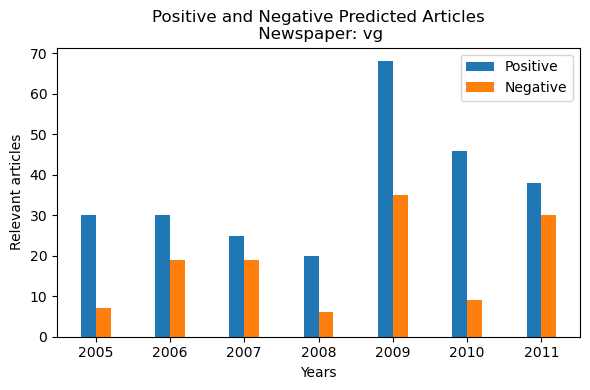

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

print(type(baseline_data))


def plot_model(data, paper):
    plot = {}
    filtered_data = [item for item in data if item["paper"] == paper]
    years = set(sorted(int(item["year"]) for item in filtered_data))
    for y in years:
        plot[y] = {"pos":0, "neg":0}

    for d in filtered_data:
        if int(d["year"]) in plot:
            if d["label"] == 1:
                plot[int(d["year"])]["pos"] += 1
            elif d["label"] == 0:
                plot[int(d["year"])]["neg"] += 1



    sorted_data = dict(sorted(plot.items()))
    years = list(sorted_data.keys())
    pos_values = [sorted_data[year]['pos'] for year in years]
    neg_values = [sorted_data[year]['neg'] for year in years]
    bar_width = 0.2
    index = np.arange(len(years))

    plt.figure(figsize=(6, 4))

    bar1 = plt.bar(index, pos_values, bar_width, label='Positive')
    bar2 = plt.bar(index + bar_width, neg_values, bar_width, label='Negative')

    plt.xlabel('Years')
    plt.ylabel('Relevant articles')
    plt.title(f'Positive and Negative Predicted Articles\n Newspaper: {paper}')
    plt.xticks(index + bar_width / 2, years)
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_model(baseline_data, "vg")        

## Creating a BERT model for classification

#### Loading BERT and tokenizer

In [60]:
# checkpoint for NorBERT location
checkpoint = "ltg/norbert3-small"
# adding autotokenizer from huggingface to bert model
tokenizer = AutoTokenizer.from_pretrained(checkpoint, trust_remote_code=True)


# manually adding binary classification configuration
id2label = {0:"Negative", 1:"Positive"}
label2id = {"Negative":0, "Positive":1}

#bert = AutoModelForSequenceClassification.from_pretrained(checkpoint, trust_remote_code=True)
bert = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, id2label=id2label, label2id=label2id, trust_remote_code=True)



c:\Users\saete\anaconda3\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [71]:
def tokenize_function(tp):
    text = tp["text"]

    tokenizer.truncation_side = "left"
    tokenized_inputs = tokenizer(
        text,
        padding="max_length",
        return_tensors="np",
        truncation=True,
        max_length=512
        )
    return tokenized_inputs

if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token":"[PAD]"})
    bert.resize_token_embeddings(len(tokenizer))


unlab_pred_nn = unlabelled_data.map(tokenize_function, batched=True)


Map:   0%|          | 0/382 [00:00<?, ? examples/s]

In [72]:

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return clf_metrics.compute(predictions=predictions, references=labels)

# Define the training arguments
training_args = TrainingArguments(
    per_device_eval_batch_size=8,
    output_dir="."
)

# Create the Trainer object
trainer = Trainer(
    model=bert,  # your fine-tuned BERT model
    args=training_args,
    compute_metrics=compute_metrics,)



c:\Users\saete\anaconda3\lib\site-packages\accelerate\accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [74]:
predictions = trainer.evaluate(eval_dataset=unlab_pred_nn)

  0%|          | 0/48 [00:00<?, ?it/s]

In [77]:
print(predictions)

{'eval_runtime': 339.9404, 'eval_samples_per_second': 1.124, 'eval_steps_per_second': 0.141}
